<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_3_CNN_Edge_Detector_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 로드

필요한 라이브러리를 로드해줍니다.

In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. 데이터셋 로드

이번에도 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터를 사용할 예정입니다. 

CIFAR-10에 대한 데이터 살펴보기 예제는 [이 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial%201%29%20CIFAR10_Softmax.ipynb)를 복습해주세요.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

1번 인덱스에 위치한 말 이미지를 불러와보겠습니다.

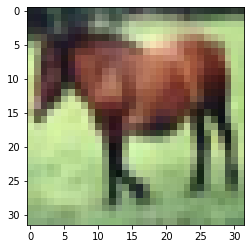

label:  [7]


In [3]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[7].astype('uint8'), cmap=plt.cm.gray)
plt.show()

print('label: ', y_train[7])

### 3. Sobel Operator 복습

review: [지난 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_2_Sobel_Opearatior.ipynb)에서는 아래와 같은 Sobel opearatoin을 만들어 보았습니다. 

그러나 for loop 기반으로 동작하는 코드는 벡터 연산을 활용하는 코드보다 동작이 느립니다. 이번 예제에서는 

```python
from skimage.color import rgb2gray ## RGB 3채널 이미지를 흑백이미지로
from skimage.filters import sobel_h, sobel_v  ## sobel operator
```

위 라이브러리들을 이용하여 edge를 detection해볼 것입니다.

지난 포스트 방식과 큰 차이는 없지만, [padding](https://brunch.co.kr/@coolmindory/37) 기법이 추가되어 이미지의 사이즈가 이전과 달라지지 않으며,

결과값들이 0에서 1사이의 값을 가지도록 후처리를 한다는 점이 다릅니다. 

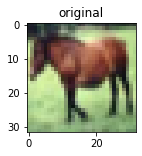

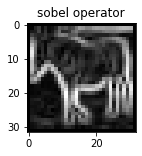

In [4]:
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

def sobel (image, thresold=180):
  grey_image = rgb2gray(image)
  convx = sobel_h(grey_image)
  convy = sobel_v(grey_image)
  output = np.sqrt(convx**2 + convy**2)
  return output

plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

### 4. Sobel Opearator의 역할을 수행하는 Convolution Layer를 학습해보자.

4장에서는 Random으로 초기화된 Convolution Layer가 Sobel Operator와 같은 역할을 수행할 수 있는지 실험해보겠습니다. 

즉, 우리의 목적은 model(img)의 결과가 sobel_operator(img) 와 비슷해지도록 model을 학습하는 것입니다. 

그러기 위해 Keras의 [Conv2d API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용하여 모델을 정의해보겠습니다. 

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```
#### 4.1. 학습 데이터 구축

정답 데이터는 더 이상 레이블인 y_train, y_test가 아니라, edge 이미지입니다. 

따라서 다음과 같이 edge 이미지들을 만들어주겠습니다.

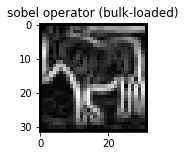

In [5]:
sobel_train = np.array([sobel(img) for img in tqdm(x_train)])
sobel_test  = np.array([sobel(img) for img in tqdm(x_test)])

plt.figure(figsize=(2,2))
plt.imshow(sobel_train[7], cmap=plt.cm.gray)
plt.title('sobel operator (bulk-loaded)')
plt.show()

#### 4.2. 모델 정의

Sobel Operator는 먼저 gray scale로 이미지를 변환한 후, 두 개의 커널로 convolution 연산을 수행하고 

마지막으로 $G_{x}$ 와 $G_{y}$ 의 크기를 잽니다.

이 과정을 3계층의 Convolution Layer들이 모사한다고 가정하고 다음과 같은 모델을 만들어보겠습니다.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU
from keras.regularizers import l1

tf.random.set_seed(2020)

model = Sequential([
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

Using TensorFlow backend.


이제 총 $N$개의 이미지에 대해 
모델이 추정한 $i$번째 edge 이미지 $model(img_{i})$와 sobel operator의 결과물인 $G^{img_{i}}$ 사이의 차이를 정량화하기 위해, 다음과 같은 손실 함수를 사용한다고 가정해보겠습니다.

$MAE= \sum_{i}^N\sum_{p \in pixels}|model(img_{i})_{p}-G_{p}^{img_{i}}|$

Keras에서는 위 손실함수를 keras.losses.MeanAbsoluteError() 에서 지원합니다.

이제 아래와 같이 MAE 손실함수를 쓰며 Adam optimizer에 의해 최적화되는 모델을 컴파일해보겠습니다.

In [7]:
## 학습가능한 필터를 가지고 있는 CNN으로 sobel operation을 학습해보자
model.compile(
          loss=keras.losses.MeanAbsoluteError(),
          optimizer=keras.optimizers.Adam())

훈련 전이므로, 다음과 같이 모델에 말 이미지를 넣으면 노이즈에 가까운 결과가 생성될 것입니다.

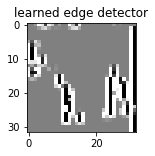

In [8]:
def learned_edge_detection (model, img):
  return model(img.reshape(-1,32,32,3)).numpy()[0,:,:,0]
  
plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.3 모델 훈련

그렇다면, 이제 모델을 훈련시켜보겠습니다.


In [9]:
model.fit(x_train, sobel_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, sobel_test),
          shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.1393 - val_loss: 0.0691
Epoch 2/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.0670 - val_loss: 0.0650
Epoch 3/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0611 - val_loss: 0.0594
Epoch 4/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0580 - val_loss: 0.0568
Epoch 5/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0555 - val_loss: 0.0543
Epoch 6/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0533 - val_loss: 0.0521
Epoch 7/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0514 - val_loss: 0.0505
Epoch 8/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0503 - val_loss: 0.0496
Epoch 9/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.0495 - val_loss: 0.0497
Epoch 10/10
1563/1563 [==============================] - 50s 32m

훈련된 모델로 edge detector를 만들어 본 후, 이를 가시화해보겠습니다.

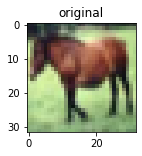

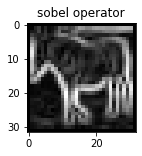

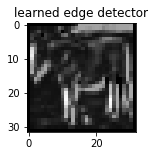

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.4 훈련 결과 확인해보기

훈련이 완료된 후에는 어느정도 말 이미지의 edge를 잘 찾아낸 것 같습니다!

이번에는 학습된 edge detector로 다양한 이미지의 edge를 찾아보겠습니다.

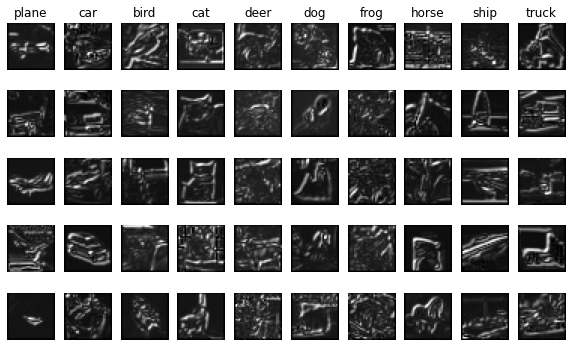

In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(10,6))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model,x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### 4.4 학습된 Weight 출력해보기

학습된 Weight들이 어떤지 출력해보겠습니다.

In [12]:
print(model.weights)

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 2) dtype=float32, numpy=
array([[[[ 0.01109453, -0.06069018],
         [ 0.18915081, -0.05205688],
         [-0.05333252, -0.00959455]],

        [[ 0.0649203 ,  0.0568919 ],
         [-0.1092179 ,  0.02306634],
         [ 0.02989459,  0.00711506]],

        [[-0.03992985, -0.06432835],
         [ 0.0080444 , -0.0332045 ],
         [ 0.04098418, -0.0118068 ]]],


       [[[-0.0567771 ,  0.0622616 ],
         [-0.05558697,  0.02111987],
         [ 0.0709452 ,  0.00408014]],

        [[-0.01262586, -0.05260767],
         [-0.05412557,  0.04363375],
         [-0.01758445,  0.00184655]],

        [[ 0.02489128,  0.06419495],
         [ 0.04531807,  0.01636272],
         [-0.07952123,  0.00633902]]],


       [[[ 0.05408377, -0.07094359],
         [-0.00749166, -0.0337784 ],
         [-0.0348018 , -0.00528692]],

        [[-0.04632561,  0.07819207],
         [ 0.0170489 ,  0.01149261],
         [ 0.01124828,  0.00146741]],

        [[ 0.000436


## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)